In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import json

# We pull the review dataset only 1.5 million so the information of review is not fully informative yet #

In [2]:
#import yelp business dataset from https://www.kaggle.com/yelp-dataset/yelp-dataset
business_df = pd.read_json('yelp_academic_dataset_business.json', lines=True, orient='columns', encoding='utf-8')

In [3]:
# Import yelp review datset from json file 
# We only use the first 100,000 data in this assignment as the data is huge and memory is error
reviews = []
with open('yelp_academic_dataset_review.json', encoding='utf-8') as fl:
    for i, line in enumerate(fl):
        reviews.append(json.loads(line))
        if i+1 >= 1500000:
            break
review_df = pd.DataFrame(reviews)

In [4]:
# select only use columns
business_df = business_df[['business_id', 'name', 'city', 'stars', 'review_count', 'categories']]
review_df = review_df[['user_id', 'business_id', 'stars']]

C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1430: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  return ax.barh(x, y, w, left=start, log=log, **kwds)


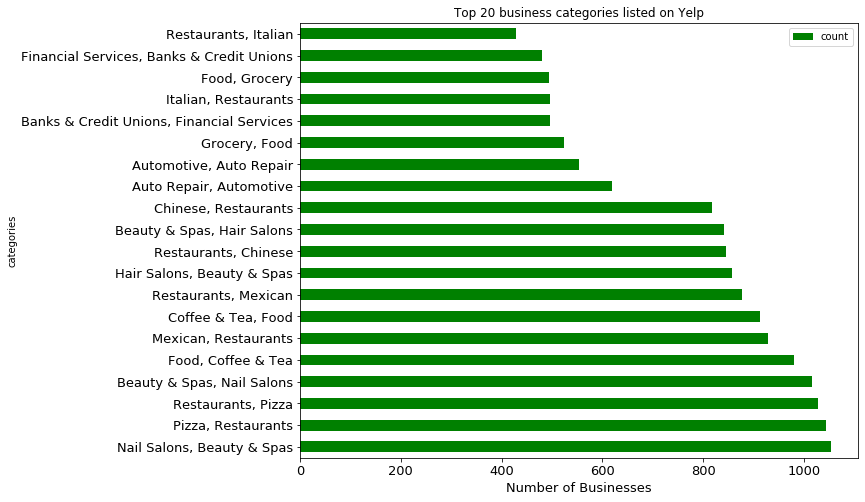

In [5]:
# groupby categories of business, most top 20 business in yelp app
business_cat = pd.DataFrame(business_df.groupby('categories').size(),columns=['count'])
business_cat.sort_values(by='count', ascending=False)[:20].plot(kind='barh',
                                                                color= 'G', 
                                                                figsize=(10,8),
                                                               title='Top 20 business categories listed on Yelp',
                                                               fontsize=13)
plt.xlabel('Number of Businesses',fontsize=13)
plt.show()

In [6]:
# filtering only restaurant business in this project since there are restaurant business more 4 times 
business_df_drop = business_df.dropna()
restaurant_df = business_df_drop[business_df_drop['categories'].str.contains("Food|Coffee|Tea|Restaurants|Bakeries|Bars|Sports Bar|Pubs|Nighlife")]
beauty_df = business_df_drop[business_df_drop['categories'].str.contains("Nail Salons|Beauty & Spas|Hair Salons")]
print('There are restaurant business of {} and beauty business of {}'.format(restaurant_df.shape[0], beauty_df.shape[0]))

There are restaurant business of 84245 and beauty business of 20520


In [7]:
restaurant_df.head(5)

,business_id,name,city,stars,review_count,categories
8,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,Champaign,4.5,5,"Ethnic Food, Food Trucks, Specialty Food, Impo..."
12,M_guz7Dj7hX0evS672wIwA,Chocolate Shoppe Ice Cream,Middleton,3.5,6,"Desserts, Food, Ice Cream & Frozen Yogurt"
20,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,3.0,5,"Food, Restaurants, Grocery, Middle Eastern"
23,mKTq1T_IAplDpHUcMzOXkw,Tipsy Ryde,Gastonia,3.5,3,"Hotels & Travel, Transportation, Taxis, Beer, ..."
24,eBEfgOPG7pvFhb2wcG9I7w,Philthy Phillys,Aurora,4.5,4,"Restaurants, Cheesesteaks, Poutineries"


## we will only use city of Toronto and Montreal as Toronto have most restaurant and Montreal is the nearest to Toronto ##

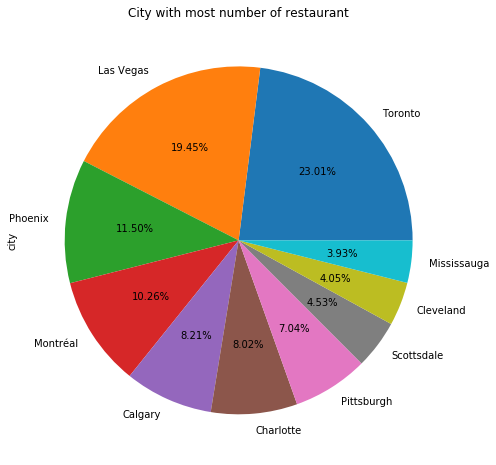

In [8]:
restaurant_df['city'].value_counts()[:10].plot(kind='pie',autopct='%1.2f%%',
                                              figsize=(10,8), title='City with most number of restaurant')

In [9]:
#filtering only restaurant in Toronto and Montreal
CND = ['Toronto','Montréal']
CND_restaurant_df = restaurant_df[restaurant_df.city.isin(CND)]

Text(0.5, 1.0, 'Distribution of Restaurant in Toronto and Montreal rating stars')

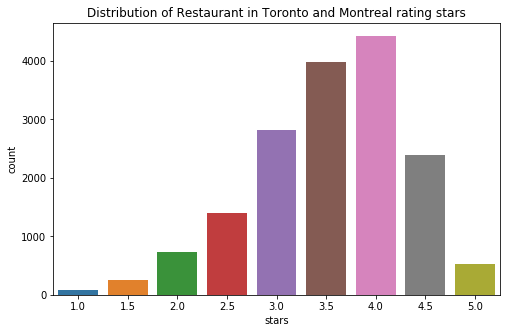

In [10]:
# plotting distribution of restaurant rating between 1 and 5
plt.figure(figsize=(8,5))
ax = sns.countplot(CND_restaurant_df['stars'])
plt.title('Distribution of Restaurant in Toronto and Montreal rating stars')

In [11]:
#we can see that there are duplicate of Starbuck restaurant in rows
STB = pd.DataFrame(CND_restaurant_df[CND_restaurant_df['name']=='Starbucks'].groupby('name').size(),columns=['count'])
print(STB.head(5))

           count
name            
Starbucks    197


In [12]:
#Hence, we aggregate review counts of all duplicate restaurant in rows 
Aggregate_name_review_cnt = CND_restaurant_df.groupby(by='name')[['review_count']].sum().sort_values(
    by='review_count',ascending=False)

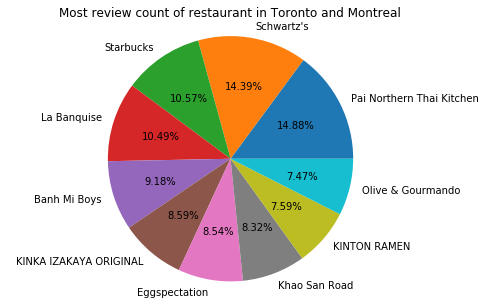

In [40]:
#Show top ten most review counts of restaurant in Toronto and Montreal
Aggregate_name_review_cnt[:10].plot(kind='pie', x='name', y='review_count', autopct='%1.2f%%', figsize=(8,5))
plt.legend().remove()
plt.ylabel('')
plt.title('Most review count of restaurant in Toronto and Montreal')
plt.axis('equal')
plt.show()

In [41]:
CND_restaurant_df.sort_values(by='review_count', ascending=False).head(10)

,business_id,name,city,restaurant_rating,review_count,categories
65694,r_BrIgzYcwo1NAuG9dLbpg,Pai Northern Thai Kitchen,Toronto,4.5,2758,"Restaurants, Thai, Specialty Food, Food, Ethni..."
78835,0W4lkclzZThpx3V65bVgig,Schwartz's,Montréal,4.0,2667,"Sandwiches, Specialty Food, Restaurants, Food,..."
177449,5T6kFKFycym_GkhgOiysIw,La Banquise,Montréal,4.0,1945,"Fast Food, Diners, Restaurants, Poutineries"
183740,RtUvSWO_UZ8V3Wpj0n077w,KINKA IZAKAYA ORIGINAL,Toronto,4.0,1592,"Restaurants, Tapas/Small Plates, Japanese, Bar..."
143305,aLcFhMe6DDJ430zelCpd2A,Khao San Road,Toronto,4.0,1542,"Thai, Restaurants"
19700,46Ld9Qc9nAx_A0jwclNZiw,Olive & Gourmando,Montréal,4.5,1385,"Bakeries, Cafes, Restaurants, Food, Sandwiches..."
133959,iGEvDk6hsizigmXhDKs2Vg,Seven Lives Tacos Y Mariscos,Toronto,4.5,1285,"Restaurants, Seafood, Mexican"
75219,cKdox2gt3L1Dbb7MpOPdWg,Au Pied de Cochon,Montréal,4.0,1273,"French, Canadian (New), Restaurants, American ..."
52101,J6qWt6XIUmIGFHX5rQJA-w,L'Avenue,Montréal,4.5,1133,"Burgers, American (New), Breakfast & Brunch, C..."
172038,N93EYZy9R0sdlEvubu94ig,Banh Mi Boys,Toronto,4.5,1097,"Sandwiches, Restaurants, Food, Vietnamese, Asi..."


In [42]:
#rename columns of restaurant rating and user rating
CND_restaurant_df.columns = ['business_id','name','city','restaurant_rating','review_count','categories']
review_df.columns = ['user_id','business_id','user_rating']

In [43]:
#Creating Total rating/review counts of individual restaurant
joined_restaurant_rating = pd.merge(CND_restaurant_df, review_df, on='business_id')
restaurant_rating_count = joined_restaurant_rating.groupby(by='name')[['review_count']].sum().sort_values(
    by='review_count',ascending=False).reset_index()
#restaurant_rating_count = (joined_restaurant_rating.
#     groupby(by = ['name'])['restaurant_rating'].
#     count().
#     reset_index().
#     rename(columns = {'restaurant_rating': 'totalRatingCount'})
#     [['name', 'totalRatingCount']]
#    )
#rename columns
restaurant_rating_count.columns = ['name','total_rating_count']

In [44]:
#Top three most total rating counts
restaurant_rating_count.head(3)

,name,total_rating_count
0,Olive & Gourmando,1943155
1,Salad King Restaurant,899652
2,360 Restaurant,703521
3,Wvrst,627946
4,Le Robin Square,519112
...,...,...
2898,The Beer Store - Church and Wellesley,3
2899,Grilly's,3
2900,Caribbean Food Factory,3
2901,Impact Kitchen,3


In [45]:
#merging total rating counts to dataframe on name column
rating_with_total_rating_count = joined_restaurant_rating.merge(restaurant_rating_count, left_on = 'name',
                                                               right_on = 'name', how='left')

In [66]:
rating_with_total_rating_count.head(3)

,business_id,name,city,restaurant_rating,review_count,categories,user_id,user_rating,total_rating_count
0,007Dg4ESDVacWcC4Vq704Q,Front Door Organics,Toronto,4.0,8,"Shopping, Food, Organic Stores, Specialty Food...",Dl6Y6sjVGL7br1O44rXDQg,5.0,72
1,007Dg4ESDVacWcC4Vq704Q,Front Door Organics,Toronto,4.0,8,"Shopping, Food, Organic Stores, Specialty Food...",AHXy4uTg_L8VFXNRufLYdQ,5.0,72
2,007Dg4ESDVacWcC4Vq704Q,Front Door Organics,Toronto,4.0,8,"Shopping, Food, Organic Stores, Specialty Food...",TaJ3hRYUW9Z82HF0qc4hFQ,4.0,72
3,007Dg4ESDVacWcC4Vq704Q,Front Door Organics,Toronto,4.0,8,"Shopping, Food, Organic Stores, Specialty Food...",9sDNyyANgUMNg0RsuR0E7A,5.0,72
4,007Dg4ESDVacWcC4Vq704Q,Front Door Organics,Toronto,4.0,8,"Shopping, Food, Organic Stores, Specialty Food...",TaJ3hRYUW9Z82HF0qc4hFQ,5.0,72


In [20]:
# finding popularity threshold for rating counts
popularity_threshold = rating_with_total_rating_count['total_rating_count'].quantile(.90)
print("Popularity_threshold : ", popularity_threshold)

Popularity_threshold :  433.0


In [47]:
# number of popular restaurant which have rating counts more than popularity threshold (10% of restaurant)
rating_popular_rest = rating_with_total_rating_count.query('total_rating_count >= @popularity_threshold')
print("number of popular restaurant is", rating_popular_rest.shape[0])

number of popular restaurant is 103545


In [67]:
rating_popular_rest.head(3)

,business_id,name,city,restaurant_rating,review_count,categories,user_id,user_rating,total_rating_count
22,LoRef3ChgZKbxUio-sHgQg,Amir,Montréal,3.0,18,"Restaurants, Lebanese, Middle Eastern",schfOYW71VamTTdfzqDlXQ,2.0,608
23,LoRef3ChgZKbxUio-sHgQg,Amir,Montréal,3.0,18,"Restaurants, Lebanese, Middle Eastern",qKpkRCPk4ycbllTfFcRbNw,3.0,608
24,LoRef3ChgZKbxUio-sHgQg,Amir,Montréal,3.0,18,"Restaurants, Lebanese, Middle Eastern",nobMBDhkieDUZHCBXHmQ8w,2.0,608


In [49]:
# drop duplicates user_id with name
user_rating = rating_popular_rest.drop_duplicates(['user_id','name'])
restaurant_features = user_rating.pivot(index='name',columns='user_id',values='restaurant_rating').fillna(0)

In [50]:
#transform the values of restaurant rating of the matrix dataframe into scipy sparse matrix for more efficient calculations
restaurant_features_matrix = csr_matrix(restaurant_features.values)

In [51]:
#k-NN is used to recommend the restaurant of item-based collaborative filtering
knn_recomm = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn_recomm.fit(restaurant_features_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [65]:
# Top ten restaurant recommendation based on your favorite restaurant (random in this case)
randomChoice = np.random.choice(restaurant_features.shape[0])
distances, indices = knn_recomm.kneighbors(restaurant_features.iloc[randomChoice].values.reshape(1, -1), n_neighbors = 11)
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for Restaurant {0} on priority basis:\n'.format(restaurant_features.index[randomChoice]))
    else:
        print('{0}: {1}'.format(i, restaurant_features.index[indices.flatten()[i]]))

Recommendations for Restaurant Balsamico Ristorante on priority basis:

1: Lemongrass Restaurant
2: Blood Brothers Brewing
3: The Red Lantern
4: Hazel's Diner
5: Douce France
6: Baker and Scone
7: Pablo Cheese Tart
8: Stadt Cafe
9: 7 Numbers Danforth
10: Kaito
